<a href="https://colab.research.google.com/github/sXeSociety/algorithms-massive-data-pagerank/blob/main/notebooks/01_dataset_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Algorithms for Massive Data – Project 3**
*Notebook 01 – Dataset Download & Initial Exploration*


In [39]:
# Import main libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Replicate repo structure in Colab
data_dir = "/content/data"
raw_dir = os.path.join(data_dir, "raw")
processed_dir = os.path.join(data_dir, "processed")

In [3]:
# Create all three directories if they do not exist yet
for d in [data_dir, raw_dir, processed_dir]:
  if not os.path.exists(d):
    os.makedirs(d)
    print(f"Created directory: {d}")
  else:
    print(f"Directory already exists: {d}")

Created directory: /content/data
Created directory: /content/data/raw
Created directory: /content/data/processed


In [22]:
# Define some global variables
use_subsample = True
subsample_fraction = 0.05
seed = 42

In [23]:
# Print recap
print("\nSetup Recap")
print(f"use_subsample = {use_subsample}")
print(f"raw_dir       = {raw_dir}")
print(f"processed_dir = {processed_dir}")


Setup Recap
use_subsample = True
raw_dir       = /content/data/raw
processed_dir = /content/data/processed


In [24]:
# In the version saved on GitHub, keep "xxxxxx" for username and key.
# When running locally on Colab, replace "xxxxxx" with your actual credentials.
os.environ["KAGGLE_USERNAME"] = "andreacorradini"
os.environ["KAGGLE_KEY"] = "f322b27e98605cdc6e73672fada0d561"

In [25]:
# Set the Kaggle dataset identifier
kaggle_dataset = "mohamedbakhet/amazon-books-reviews"

In [26]:
# Check if the dataset already exists in RAW_DIR
existing_files = []
for f in os.listdir(raw_dir):
    if f.lower().endswith(".csv"):
        existing_files.append(f)

if existing_files:
  print("Dataset already present in raw_dir, skipping download.")
else:
  print("Dataset not found in raw_dir, downloading from Kaggle.")
  !kaggle datasets download -d {kaggle_dataset} -p {raw_dir} --unzip
  print("Download extraction completed.")
  print("Files now in raw_dir:")
  for f in os.listdir(raw_dir):
    print(" -", f)

Dataset already present in raw_dir, skipping download.


In [27]:
ratings_path = os.path.join(raw_dir, "Books_rating.csv")
np.random.seed(seed)

# Does the file exist?
if not os.path.exists(ratings_path):
  print(f"ERROR: ratings file not found at {ratings_path}")

else:
  if use_subsample:
    print("Using subsample mode")
    # Charge the whole file
    df_ratings = pd.read_csv(ratings_path)
    print(f"Full dataset shape before subsample: {df_ratings.shape}")
    # Fractional sample
    df_ratings = df_ratings.sample(
        frac = subsample_fraction,
        random_state = seed)
    print(f"Subsampled dataset shape: {df_ratings.shape}")
    # Save subsample in processed/
    subsample_path = os.path.join(processed_dir, "ratings_subsample.csv")
    df_ratings.to_csv(subsample_path, index = False)
    print(f"Subsample saved to: {subsample_path}")

  else:
     print("Loading full dataset (no subsample)...")
     df_ratings = pd.read_csv(ratings_path)
     print(f"Full dataset shape: {df_ratings.shape}")

  # Some diagnostic informations
  print("Final dataframe shape:", df_ratings.shape)
  print(df_ratings.columns)
  print(df_ratings.head())

Using subsample mode
Full dataset shape before subsample: (3000000, 10)
Subsampled dataset shape: (150000, 10)
Subsample saved to: /content/data/processed/ratings_subsample.csv
Final dataframe shape: (150000, 10)
Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')
                 Id                                              Title  Price  \
2945667  B0006CR6U4  A dictionary of the Targumim, the Talmud Babli...    NaN   
2352586  0897166159           Espresso Coffee: Professional Techniques    NaN   
1531260  0736693408  The First King of Shannara (The Sword of Shann...    NaN   
941910   0395051029             Wuthering Heights (Riverside editions)    NaN   
2582125  4770016050  A Cat, a Man, and Two Women (Japans Modern Wri...    NaN   

                User_id                 profileName review/helpfulness  \
2945667  A303XPDO694V6X                       Ariel  

In [28]:
# Compute the distinct number of users and book
# Is the subsample still rich or did I cut it too aggresively?
n_users = df_ratings["User_id"].nunique()
n_books = df_ratings["Id"].nunique()
print(f"Distinct users: {n_users}")
print(f"Distinct books: {n_books}")

Distinct users: 95746
Distinct books: 53940


In [29]:
# Review distribution per user and book
# Is this graph just a collection of almost-isolated nodes, or do we have a network where information can actually flow?
user_reviews = df_ratings["User_id"].value_counts()
book_reviews = df_ratings["Id"].value_counts()

print("\nReviews per user:")
print(f"min:    {user_reviews.min()}")
print(f"median: {user_reviews.median()}")
print(f"mean:   {user_reviews.mean():.2f}")
print(f"max:    {user_reviews.max()}")

print("\nReviews per book:")
print(f"min:    {book_reviews.min()}")
print(f"median: {book_reviews.median()}")
print(f"mean:   {book_reviews.mean():.2f}")
print(f"max:    {book_reviews.max()}")


Reviews per user:
min:    1
median: 1.0
mean:   1.28
max:    290

Reviews per book:
min:    1
median: 1.0
mean:   2.78
max:    339


In [30]:
# Already active items
# How many items are actually doing something interesting for the graph, and not just appearing once and disappearing?
# A user with two or more reviews can create at least one pair of books that share the same user.
active_users = (user_reviews >= 2).sum()
active_books = (book_reviews >= 2).sum()
print(f"\nUsers with >= 2 reviews: {active_users}")
print(f"Books with >= 2 reviews: {active_books}")


Users with >= 2 reviews: 11647
Books with >= 2 reviews: 19848


In [33]:
# df_ratings_clean is going to be the subsample to use for describing the dataset
# Rename columns to make them more understandable and keep only what's useful
df_ratings_clean = df_ratings.rename(columns = {
    "User_id": "user_id",
    "Id": "book_id",
    "review/score": "rating"
})[["user_id", "book_id", "rating"]]

print("Shape df_ratings_clean:", df_ratings_clean.shape)
print(df_ratings_clean.head())

clean_path = os.path.join(processed_dir, "ratings_subsample_clean.csv")
df_ratings_clean.to_csv(clean_path, index = False)
print(f"Clean subsample saved in: {clean_path}")

Shape df_ratings_clean: (150000, 3)
                user_id     book_id  rating
2945667  A303XPDO694V6X  B0006CR6U4     4.0
2352586  A3780H4TM9RMB8  0897166159     2.0
1531260  A1AX6VPDQQZDPV  0736693408     5.0
941910   A35RQKCCCQ62O0  0395051029     4.0
2582125  A2IJQDE1I4SIJT  4770016050     5.0
Clean subsample salvato in: /content/data/processed/ratings_subsample_clean.csv



Ratings distribution:
rating
1.0    10034
2.0     7597
3.0    12656
4.0    29394
5.0    90319
Name: count, dtype: int64
rating
1.0    0.066893
2.0    0.050647
3.0    0.084373
4.0    0.195960
5.0    0.602127
Name: proportion, dtype: float64


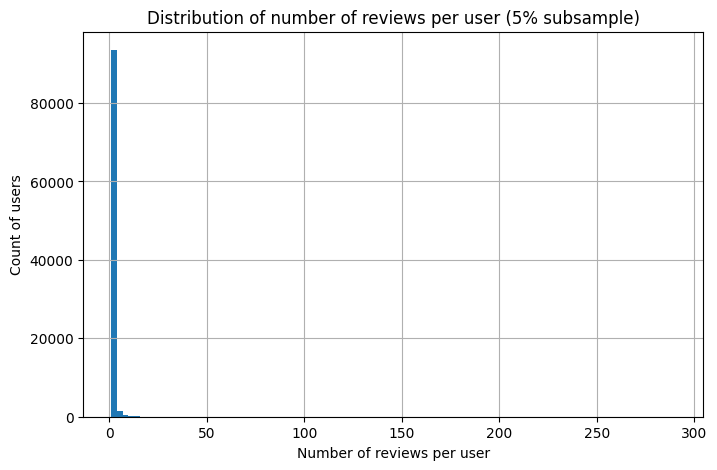

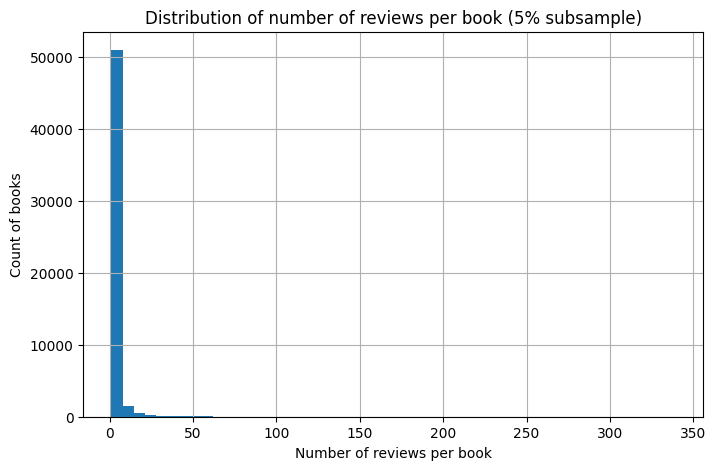

In [43]:
print("\nRatings distribution:")
print(df_ratings_clean["rating"].value_counts().sort_index())
print(df_ratings_clean["rating"].value_counts(normalize=True).sort_index())

plt.figure(figsize=(8, 5))
user_reviews.hist(bins=100)
plt.xlabel("Number of reviews per user")
plt.ylabel("Count of users")
plt.title("Distribution of number of reviews per user (5% subsample)")
plt.show()

plt.figure(figsize=(8, 5))
book_reviews.hist(bins=50)
plt.xlabel("Number of reviews per book")
plt.ylabel("Count of books")
plt.title("Distribution of number of reviews per book (5% subsample)")
plt.show()

In [36]:
# df_core is the dataset I am going to use to create the graph and do PageRank
# The graph will have way less noise, it is going to be more connected and interesting
min_reviews = 2
user_counts = df_ratings_clean["user_id"].value_counts()
book_counts = df_ratings_clean["book_id"].value_counts()

# Active users and books with at least two reviews
active_users = user_counts[user_counts >= min_reviews].index
active_books = book_counts[book_counts >= min_reviews].index

df_core = df_ratings_clean[
    df_ratings_clean["user_id"].isin(active_users)
    & df_ratings_clean["book_id"].isin(active_books)
].copy()

print("Shape df_core:", df_core.shape)
print("Distinct users in core:", df_core["user_id"].nunique())
print("Distinct books in core:", df_core["book_id"].nunique())
print(df_core.head())

core_path = os.path.join(processed_dir, "ratings_core_for_graph.csv")
df_core.to_csv(core_path, index = False)
print(f"Core dataset saved in: {core_path}")

Shape df_core: (30736, 3)
Distinct users in core: 11104
Distinct books in core: 10592
                user_id     book_id  rating
941910   A35RQKCCCQ62O0  0395051029     4.0
2379833  A319KYEIAZ3SON  0670569798     5.0
2911594  A2X86K2EZCV0U1  B000GRDY1O     4.0
2682023  A1JLKPA3EPLFCP  0774032448     5.0
2306673  A1I2O9Y3X3HXLS  B000GRORC4     5.0
Core dataset saved in: /content/data/processed/ratings_core_for_graph.csv
